# Problem description

The aim of this project is to investigate different techniques of feature scaling and their influence on different regression models quality.  
The investigation is based on "MatNavi Mechanical properties of low-alloy steels" dataset: https://www.kaggle.com/datasets/konghuanqing/matnavi-mechanical-properties-of-lowalloy-steels?resource=download which was previously cleaned of otliers.

# 1. Imports and loading data

In [1]:
import urllib.request
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
#url = 'https://raw.githubusercontent.com/ElenaNKn/feature_importance_methods/master/mechanical_properties_low-alloy_steels_cleaned.csv'
#filename = 'mechanical_properties_low-alloy_steels_cleaned.csv'
#urllib.request.urlretrieve(url, filename)

In [3]:
df = pd.read_csv('mechanical_properties_low-alloy_steels_cleaned.csv', header=0, sep=',')

In [4]:
df.head()

,Alloy code,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%)
0,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27,342,490,30,71
1,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100,338,454,27,72
2,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200,337,465,23,69
3,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300,346,495,21,70
4,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400,316,489,26,79


In [5]:
# handle headers of a dataframe

df.columns = df.columns.str.lower().str.lstrip()
df.columns = df.columns.str.replace('+', 'and', regex=True).str.replace('°c', 'celcius', regex=True)
df.columns = df.columns.str.replace('0.2% ', '', regex=True).str.replace('%', 'perc', regex=True)
df.columns = df.columns.str.replace(' ', '_').str.replace('+', 'and', regex=True)
df.columns = df.columns.str.replace('(', '', regex=True).str.replace(')', '', regex=True)
df.columns = df.columns.str.lower().str.replace('ta', 'ti')

In [6]:
del df['ceq']
del df['alloy_code']
del df['tensile_strength_mpa']
del df['elongation_perc']
del df['reduction_in_area_perc']

In [7]:
df.head()

,c,si,mn,p,s,ni,cr,mo,cu,v,al,n,nb_and_ti,temperature_celcius,proof_stress_mpa
0,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,27,342
1,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,100,338
2,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,200,337
3,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,300,346
4,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,400,316


# 2. Setting up the validation framework

In [8]:
# create list of feature columns names
list_features = [
    'c', 'si', 'mn', 'p', 's', 'ni', 'cr',
    'mo', 'cu', 'v', 'al', 'n',
    'nb_and_ti', 'temperature_celcius'
    ]

In [9]:
# splitting into train - val - test datasets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

# create dataframes for feature variables

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# create dataframes for target variables

dy_train = df_train.proof_stress_mpa
dy_val = df_val.proof_stress_mpa
dy_test = df_test.proof_stress_mpa

df_train.drop('proof_stress_mpa', axis=1, inplace=True)
df_val.drop('proof_stress_mpa', axis=1, inplace=True)
df_test.drop('proof_stress_mpa', axis=1, inplace=True)

# 3. Modeling without feature handling

## 3.1. Ridge linear regression model

In [10]:
from sklearn.linear_model import Ridge

rlr = Ridge()

In [16]:
rlr.fit(df_train, dy_train)
MSE = np.sqrt(mean_squared_error(rlr.predict(df_val), dy_val))
print("Mean squared error (ridge regression): \n%.3f" % (MSE))

Mean squared error (ridge regression): 
80.187


In [17]:
# perform parameters tuning

alpha = [0, 1, 5, 10, 15, 20, 50]
mean_mape_score = []

for a in alpha:
    rlr = Ridge(alpha=a)
    rlr.fit(df_train, dy_train)
    mse = np.sqrt(mean_squared_error(rlr.predict(df_val), dy_val))
    print('%4s     %.3f' % (a, mse))

   0     56.636
   1     58.140
   5     62.186
  10     65.130
  15     67.579
  20     69.800
  50     80.187


From the results obtained we see that the best MSE values are for alpha=0. According to scikit-learn documentation it's better to use simple linear regression model in such a case.

## 3.2. Linear regression model

In [18]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [19]:
lr.fit(df_train, dy_train)
MSE = np.sqrt(mean_squared_error(lr.predict(df_val), dy_val))
print("Mean squared error (linear regression): \n%.3f" % (MSE))

Mean squared error (linear regression): 
56.636


## 3.3. Decision tree model

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [22]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(df_train, dy_train)
MSE = np.sqrt(mean_squared_error(dt.predict(df_val), dy_val))
print("Mean squared error (decision tree regression): \n%.3f" % (MSE))

Mean squared error (decision tree regression): 
36.712


In [25]:
print('depth   mse')
for depth in range(1, 20, 1): 
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(df_train, dy_train)
    MSE = np.sqrt(mean_squared_error(dt.predict(df_val), dy_val))
    print('%4s     %.3f' % (depth, MSE))

depth   mse
   1     90.245
   2     70.963
   3     58.336
   4     49.071
   5     44.398
   6     37.871
   7     37.434
   8     34.339
   9     36.161
  10     34.881
  11     36.930
  12     37.165
  13     33.704
  14     35.976
  15     35.119
  16     35.958
  17     36.781
  18     35.115
  19     36.712


From the results obtained we'll choose depth = [8, 10]. Now let's find optimal min_samples_leaf

In [28]:
scores = []

for depth in [8, 9, 10]:
    for s in [1, 5, 10, 15, 20]:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s, random_state=1)
        dt.fit(df_train, dy_train)
        MSE = np.sqrt(mean_squared_error(dt.predict(df_val), dy_val))
        
        scores.append((depth, s, MSE))
        
columns = ['max_depth', 'min_samples_leaf', 'MSE']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['MSE'])
df_scores_pivot.round(3)

MSE                
max_depth             8       9       10
min_samples_leaf                        
1                 34.490  35.348  34.170
5                 36.885  36.516  36.438
10                41.392  41.296  40.989
15                48.225  48.225  48.225
20                45.346  45.346  45.346

In [29]:
# total decision tree model

dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=1, random_state=1)
dt.fit(df_train, dy_train)
MSE = np.sqrt(mean_squared_error(dt.predict(df_val), dy_val))
print("Mean squared error (decision tree regression): \n%.3f" % (MSE))

Mean squared error (decision tree regression): 
34.170


## 3.4. CNN model

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from numpy.random import seed
from tensorflow.keras.utils import set_random_seed

In [42]:
n_inputs = df_train.shape[1]
n_outputs = 1

loss = 'mse'

# settingt the seed
seed(0)
set_random_seed(0)

In [43]:
def model_create(learning_rate=0.01, size_inner=128, drop_rate=0.2):
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model = Sequential()
    model.add(Dense(128, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(size_inner, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss=loss, optimizer=optimizer)
    
    history = model.fit(df_train, dy_train, verbose = 0, epochs=300)
    
    mse = np.sqrt(model.evaluate(df_val, dy_val, verbose=0))
    return mse

In [45]:
scores = []

rate = [0.0001, 0.001, 0.01, 0.1]

for learning_rate in rate:
    mse = model_create(learning_rate=learning_rate)
    scores.append((learning_rate, round(mse,3)))

scores

[(0.0001, 189.372), (0.001, 55.484), (0.01, 66.626), (0.1, 123.499)]

In [47]:
scores = []

sizes = [8, 16, 32, 64, 128]
rates = [0.1, 0.2, 0.4, 0.6, 0.8]

for size in sizes:
    for rate in rates:
        mse = model_create(learning_rate=0.001, size_inner=size, drop_rate=rate)
        scores.append((size, rate, round(mse,3)))
        
columns = ['size_inner', 'drop_rate', 'mse']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index='size_inner', columns=['drop_rate'], values=['mse'])
df_scores_pivot.round(3)

mse                                 
drop_rate      0.1     0.2     0.4     0.6      0.8
size_inner                                         
8           59.264  57.989  57.993  59.455   66.507
16          56.589  58.470  57.964  58.037   73.218
32          57.358  56.378  56.777  61.364   86.815
64          53.881  60.050  56.243  66.085  124.255
128         54.427  54.752  59.175  89.486  143.557

In [53]:
MSE = model_create(learning_rate=0.001, size_inner=128, drop_rate=0.1)

print("Mean squared error (CNN): \n%.3f" % (MSE))

Mean squared error (CNN): 
54.396


# 4. Feature scaling and models updating

## 4.1. Scaling

There are different scaling methods. We'll consider "Min-max normalization", "Max normalization" and "Standardization" (also known as "Z-score normalization") as the most common used.

In [74]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

### 4.1.1. Min-max normalization

In [143]:
min_max_scaler = MinMaxScaler()
my_features = min_max_scaler.fit_transform(df_train[list_features]).reshape(-1, 14)
x = pd.DataFrame(my_features, columns = df_train.columns)
x

,c,si,mn,p,s,ni,cr,mo,cu,v,al,n,nb_and_ti,temperature_celcius
0,0.280,0.852941,0.188679,0.166667,0.368421,0.316667,0.770992,0.680297,0.60,0.800000,0.020833,0.688,0.0,1.000000
1,0.760,0.000000,0.311321,0.250000,0.315789,0.533333,0.763359,0.925651,0.56,0.900000,0.000000,0.520,0.0,0.919743
2,0.160,0.147059,0.226415,0.166667,0.368421,0.133333,0.045802,0.375465,0.52,0.000000,0.041667,0.256,0.0,0.759230
3,0.440,0.382353,0.160377,0.500000,0.315789,0.000000,0.035115,0.004461,0.20,0.000000,0.083333,0.248,0.0,0.277689
4,1.000,0.117647,0.264151,0.416667,0.473684,0.233333,0.076336,0.018587,0.80,0.000000,0.000000,0.656,0.0,0.598716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,0.800,0.088235,0.226415,0.166667,0.263158,0.850000,0.816794,0.955390,0.24,0.766667,0.062500,0.576,0.0,0.919743
545,0.320,0.441176,0.896226,0.416667,0.578947,1.000000,0.061069,0.390335,0.96,0.000000,0.125000,0.368,0.0,0.919743
546,0.600,0.176471,0.207547,0.375000,0.526316,0.000000,0.056489,0.010409,0.20,0.000000,0.187500,0.280,0.0,0.759230
547,0.600,0.176471,0.207547,0.375000,0.526316,0.000000,0.056489,0.010409,0.20,0.000000,0.187500,0.280,0.0,0.598716


In [144]:
y = dy_train.values.reshape(-1, 1)

In [145]:
my_features_val = min_max_scaler.transform(df_val[list_features]).reshape(-1, 14)
x_val = pd.DataFrame(my_features_val, columns = df_train.columns)
y_val = dy_val.values.reshape(-1, 1)

### 4.1.2. Max normalization

In [159]:
max_scaler = MaxAbsScaler(copy=True)
my_features2 = max_scaler.fit_transform(df_train[list_features]).reshape(-1, 14)
x_2 = pd.DataFrame(my_features2, columns = df_train.columns)
x_2

,c,si,mn,p,s,ni,cr,mo,cu,v,al,n,nb_and_ti,temperature_celcius
0,0.470588,0.903846,0.418919,0.333333,0.454545,0.316667,0.770992,0.681481,0.60,0.800000,0.06,0.740000,0.0,1.000000
1,0.823529,0.346154,0.506757,0.400000,0.409091,0.533333,0.763359,0.925926,0.56,0.900000,0.04,0.600000,0.0,0.923077
2,0.382353,0.442308,0.445946,0.333333,0.454545,0.133333,0.045802,0.377778,0.52,0.000000,0.08,0.380000,0.0,0.769231
3,0.588235,0.596154,0.398649,0.600000,0.409091,0.000000,0.035115,0.008148,0.20,0.000000,0.12,0.373333,0.0,0.307692
4,1.000000,0.423077,0.472973,0.533333,0.545455,0.233333,0.076336,0.022222,0.80,0.000000,0.04,0.713333,0.0,0.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,0.852941,0.403846,0.445946,0.333333,0.363636,0.850000,0.816794,0.955556,0.24,0.766667,0.10,0.646667,0.0,0.923077
545,0.500000,0.634615,0.925676,0.533333,0.636364,1.000000,0.061069,0.392593,0.96,0.000000,0.16,0.473333,0.0,0.923077
546,0.705882,0.461538,0.432432,0.500000,0.590909,0.000000,0.056489,0.014074,0.20,0.000000,0.22,0.400000,0.0,0.769231
547,0.705882,0.461538,0.432432,0.500000,0.590909,0.000000,0.056489,0.014074,0.20,0.000000,0.22,0.400000,0.0,0.615385


In [160]:
my_features_val2 = max_scaler.transform(df_val[list_features]).reshape(-1, 14)
x_val2 = pd.DataFrame(my_features_val2, columns = df_train.columns)

### 4.1.3. Standartization

Standartization may be applied only to features, that initially has normal (Gaussian) distribution. In other case standartization will lead to incorrect predictions.  
So first of all, we'll check out distributions of our feature variables. The simplest way is to plot a scatter plot matrix and check plots, which are at it's diagonal.

In [148]:
import seaborn as sb

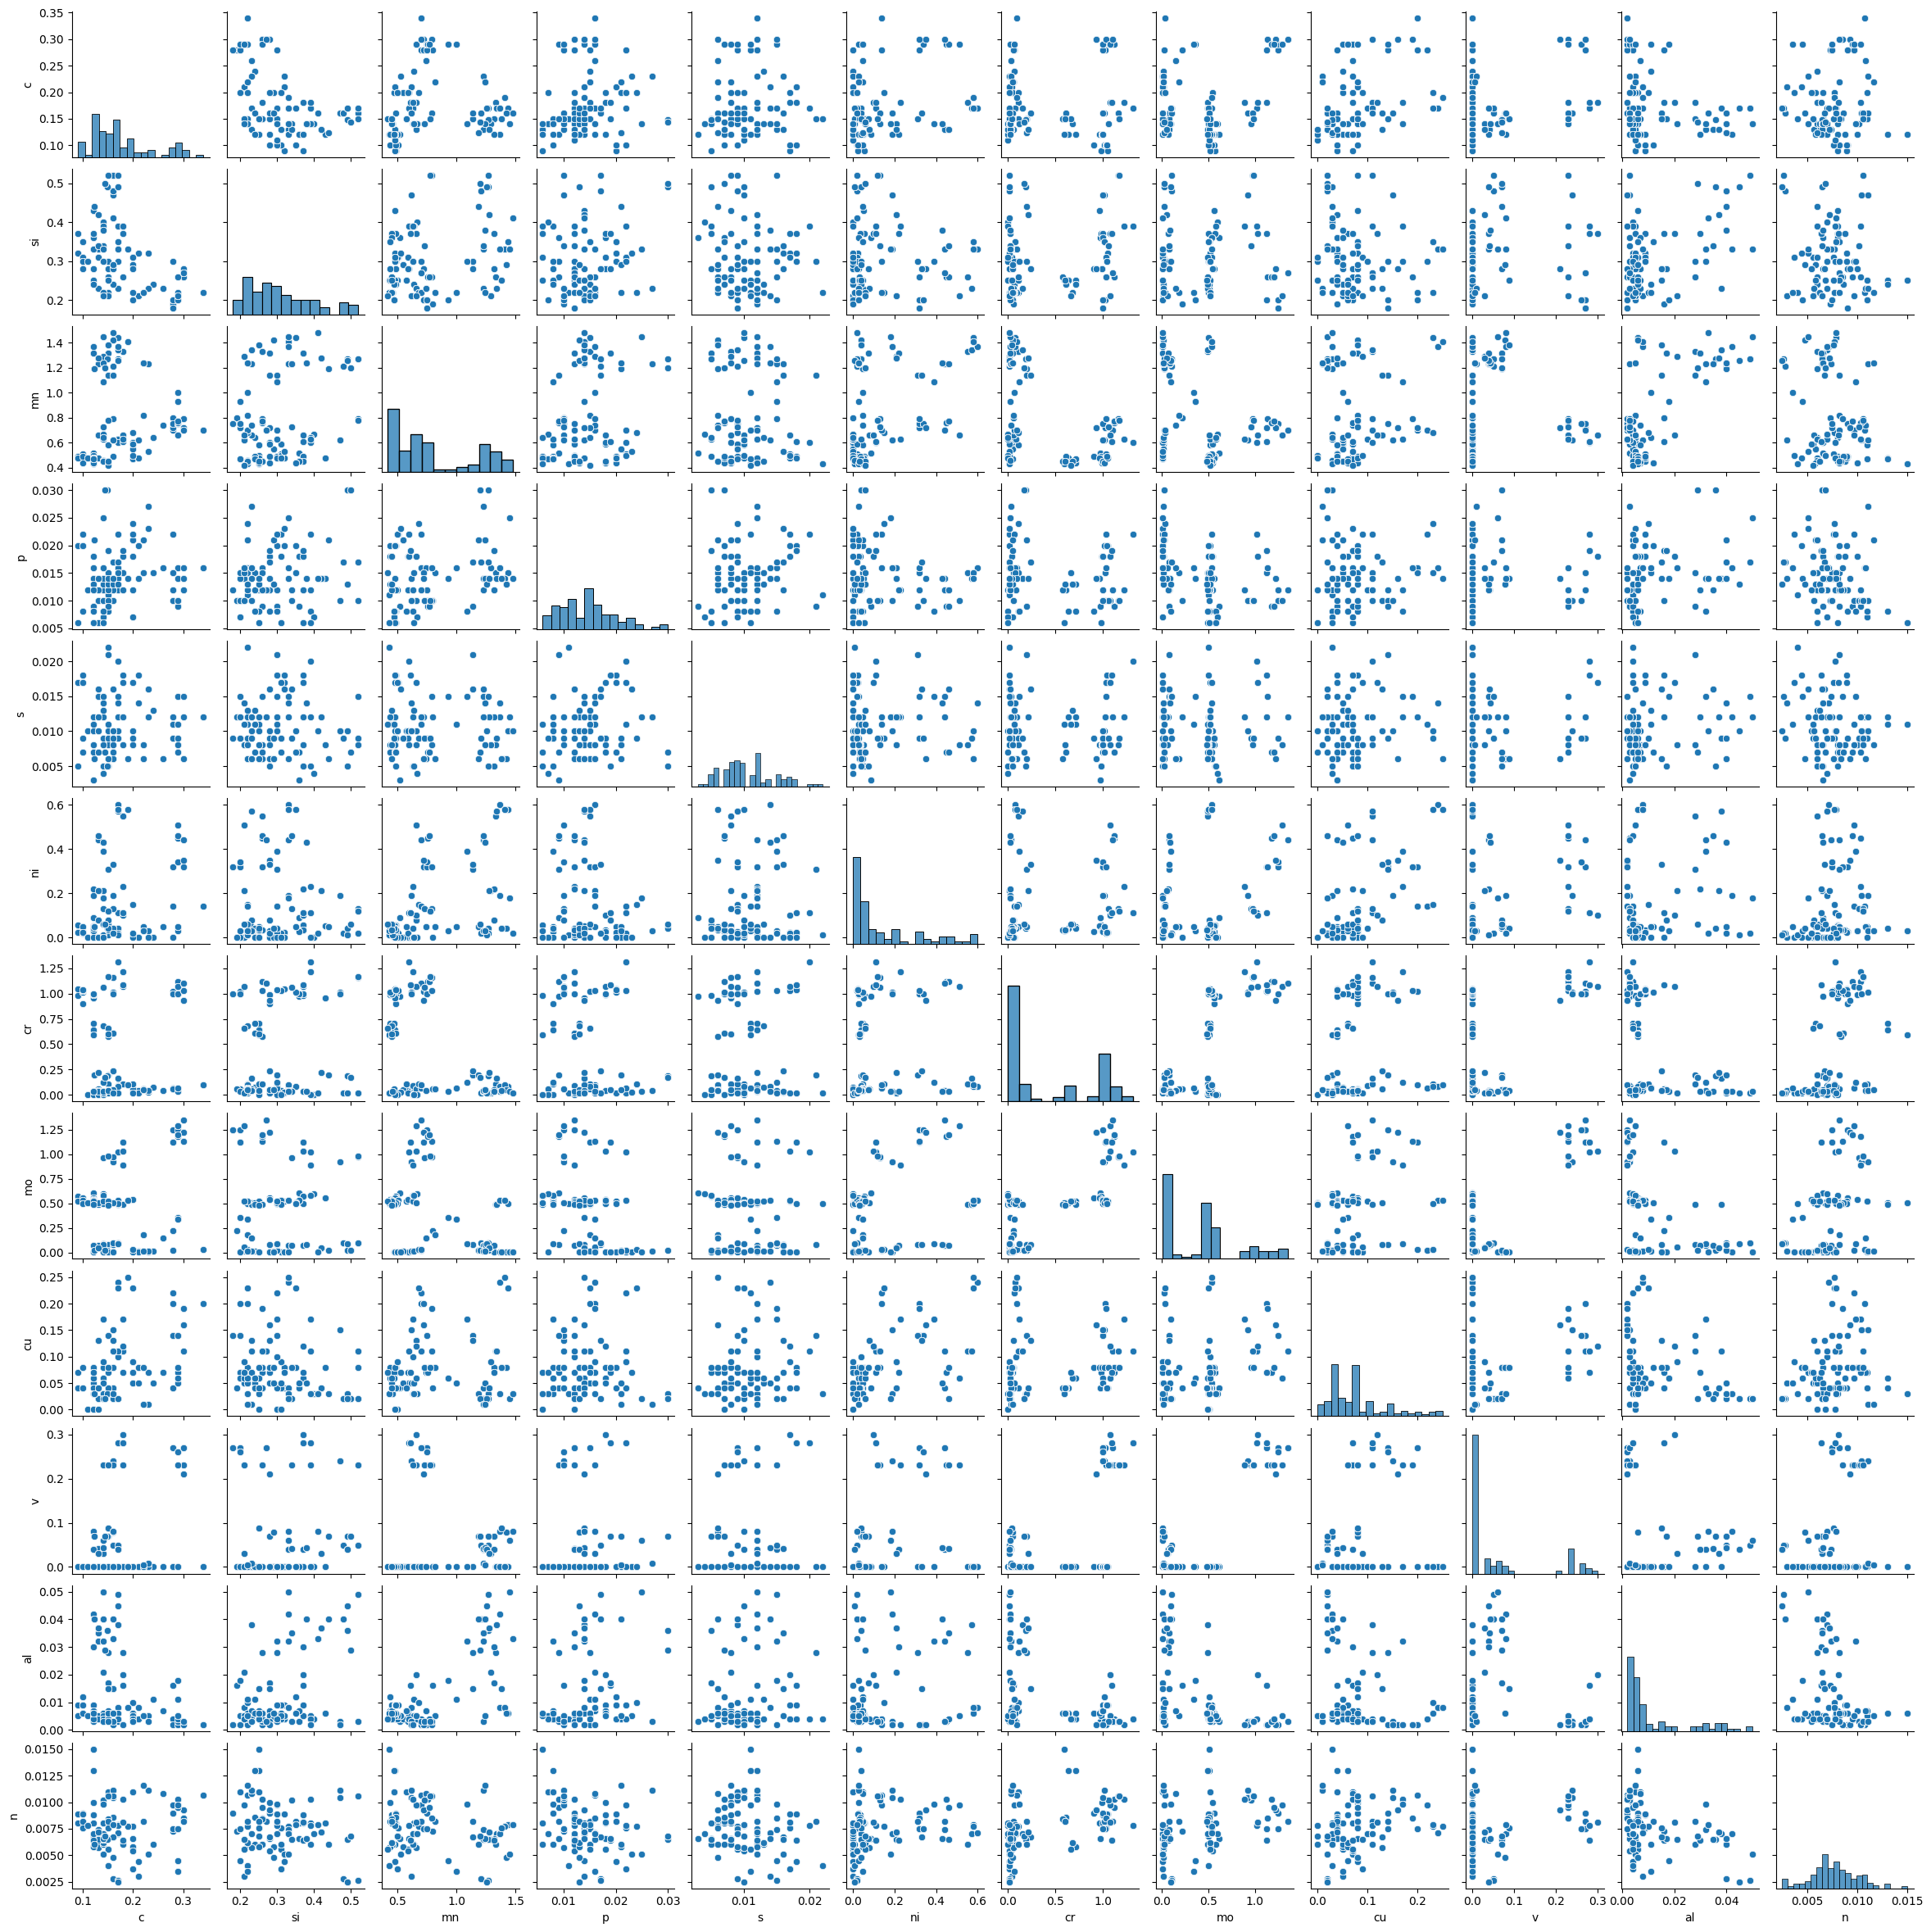

In [132]:
feature_norm = [
    'c', 'si', 'mn', 'p', 's', 'ni', 'cr',
    'mo', 'cu', 'v', 'al', 'n'
    ]

sb.pairplot(df[feature_norm],  height=2)

We see from the plot above, that there are only few features, whose distribution may considered to be normal. We'll stardardize these features and apply min-max normalization to other ones.

In [149]:
feature_norm = [
    'p', 's', 'n'
    ]
feature_rest = list_features.copy()
for a in feature_norm:
    feature_rest.remove(a)

In [150]:
stand_scaler = StandardScaler()
my_features3_1 = stand_scaler.fit_transform(df_train[feature_norm]).reshape(-1, 3)
x_3_1 = pd.DataFrame(my_features3_1, columns = feature_norm)

my_features3_2 = min_max_scaler.fit_transform(df_train[feature_rest]).reshape(-1, 11)
x_3_2 = pd.DataFrame(my_features3_2, columns = feature_rest)

x_3 = x_3_1.join(x_3_2)
x_3

,p,s,n,c,si,mn,ni,cr,mo,cu,v,al,nb_and_ti,temperature_celcius
0,-0.866808,-0.172429,1.523274,0.280,0.852941,0.188679,0.316667,0.770992,0.680297,0.60,0.800000,0.020833,0.0,1.000000
1,-0.489726,-0.412082,0.606590,0.760,0.000000,0.311321,0.533333,0.763359,0.925651,0.56,0.900000,0.000000,0.0,0.919743
2,-0.866808,-0.172429,-0.833913,0.160,0.147059,0.226415,0.133333,0.045802,0.375465,0.52,0.000000,0.041667,0.0,0.759230
3,0.641520,-0.412082,-0.877564,0.440,0.382353,0.160377,0.000000,0.035115,0.004461,0.20,0.000000,0.083333,0.0,0.277689
4,0.264438,0.306879,1.348667,1.000,0.117647,0.264151,0.233333,0.076336,0.018587,0.80,0.000000,0.000000,0.0,0.598716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,-0.866808,-0.651736,0.912151,0.800,0.088235,0.226415,0.850000,0.816794,0.955390,0.24,0.766667,0.062500,0.0,0.919743
545,0.264438,0.786187,-0.222790,0.320,0.441176,0.896226,1.000000,0.061069,0.390335,0.96,0.000000,0.125000,0.0,0.919743
546,0.075897,0.546533,-0.702958,0.600,0.176471,0.207547,0.000000,0.056489,0.010409,0.20,0.000000,0.187500,0.0,0.759230
547,0.075897,0.546533,-0.702958,0.600,0.176471,0.207547,0.000000,0.056489,0.010409,0.20,0.000000,0.187500,0.0,0.598716


In [151]:
my_features3_1 = stand_scaler.transform(df_val[feature_norm]).reshape(-1, 3)
x_val_3_1 = pd.DataFrame(my_features3_1, columns = feature_norm)

my_features3_2 = min_max_scaler.transform(df_val[feature_rest]).reshape(-1, 11)
x_val_3_2 = pd.DataFrame(my_features3_2, columns = feature_rest)

x_val3 = x_val_3_1.join(x_val_3_2)

## 4.2. Linear regression model

In [153]:
lr.fit(x, y)
MSE = np.sqrt(mean_squared_error(lr.predict(x_val), y_val))
print("Mean squared error (linear regression with min-max normalization): \n%.3f" % (MSE))

Mean squared error (linear regression with min-max normalization): 
56.636


In [161]:
lr.fit(x_2, y)
MSE = np.sqrt(mean_squared_error(lr.predict(x_val2), y_val))
print("Mean squared error (linear regression with standardization): \n%.3f" % (MSE))

Mean squared error (linear regression with standardization): 
56.636


In [157]:
lr.fit(x_3, y)
MSE = np.sqrt(mean_squared_error(lr.predict(x_val3), y_val))
print("Mean squared error (linear regression with standardization): \n%.3f" % (MSE))

Mean squared error (linear regression with standardization): 
56.636


As we see, feature scaling didn't affect the accuracy of linear regression model at all.   

 Let's check out, whether feature scaling influences on ridge linear regression model

## 4.3. Ridge linear regression model

In [162]:
alpha = [0, 1, 5, 10, 15, 20, 50, 100, 150, 200]
mean_mape_score = []

print("Dependence of MSE from penalty coefficients for Ridge regression with min-max normalization")

for a in alpha:
    rlr = Ridge(alpha=a)
    rlr.fit(x, y)
    mse = np.sqrt(mean_squared_error(rlr.predict(x_val), y_val))
    print('%4s     %.3f' % (a, mse))

Dependence of MSE from penalty coefficients for Ridge regression with min-max normalization
   0     56.636
   1     56.207
   5     55.723
  10     56.533
  15     58.052
  20     59.890
  50     71.271
 100     84.691
 150     93.127
 200     98.858


Results obtained show that feature scalling helped to improve ridge model (we obtained that MSE value is better for alpha=5). Actually it's quite expectable, because Ridge regression imposes a penalty on the squared size of the coefficients. And penalty coefficient alpha is the same for all variables regardless their values. And if values differs a lot, it may cause problems with Ridge regression model.

In [163]:
alpha = [0, 1, 5, 10, 15, 20, 50, 100, 150, 200]

print("Dependence of MSE from penalty coefficients for Ridge regression with max normalization")

for a in alpha:
    rlr = Ridge(alpha=a)
    rlr.fit(x_2, y)
    mse = np.sqrt(mean_squared_error(rlr.predict(x_val2), y_val))
    print('%4s     %.3f' % (a, mse))

Dependence of MSE from penalty coefficients for Ridge regression with max normalization
   0     56.636
   1     55.956
   5     55.587
  10     56.905
  15     58.915
  20     61.178
  50     73.942
 100     87.737
 150     95.982
 200     101.440


In [164]:
alpha = [0, 1, 5, 10, 15, 20, 50, 100, 150, 200]

print("Dependence of MSE from penalty coefficients for Ridge regression with standardization")

for a in alpha:
    rlr = Ridge(alpha=a)
    rlr.fit(x_3, y)
    mse = np.sqrt(mean_squared_error(rlr.predict(x_val3), y_val))
    print('%4s     %.3f' % (a, mse))

Dependence of MSE from penalty coefficients for Ridge regression with standardization
   0     56.636
   1     56.290
   5     55.873
  10     56.588
  15     57.999
  20     59.755
  50     71.052
 100     84.612
 150     93.129
 200     98.896
